In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

In [12]:
data = pd.read_csv("cleaned_amp_data.csv")

In [13]:
data = data.drop(['Target Activity_Viruses','NAME', 'SEQUENCE', 'SYNTHESIS TYPE', 'TARGET GROUP', 'TARGET OBJECT'],axis=1)

In [14]:
data_filledna = data.fillna(0)

<AxesSubplot:>

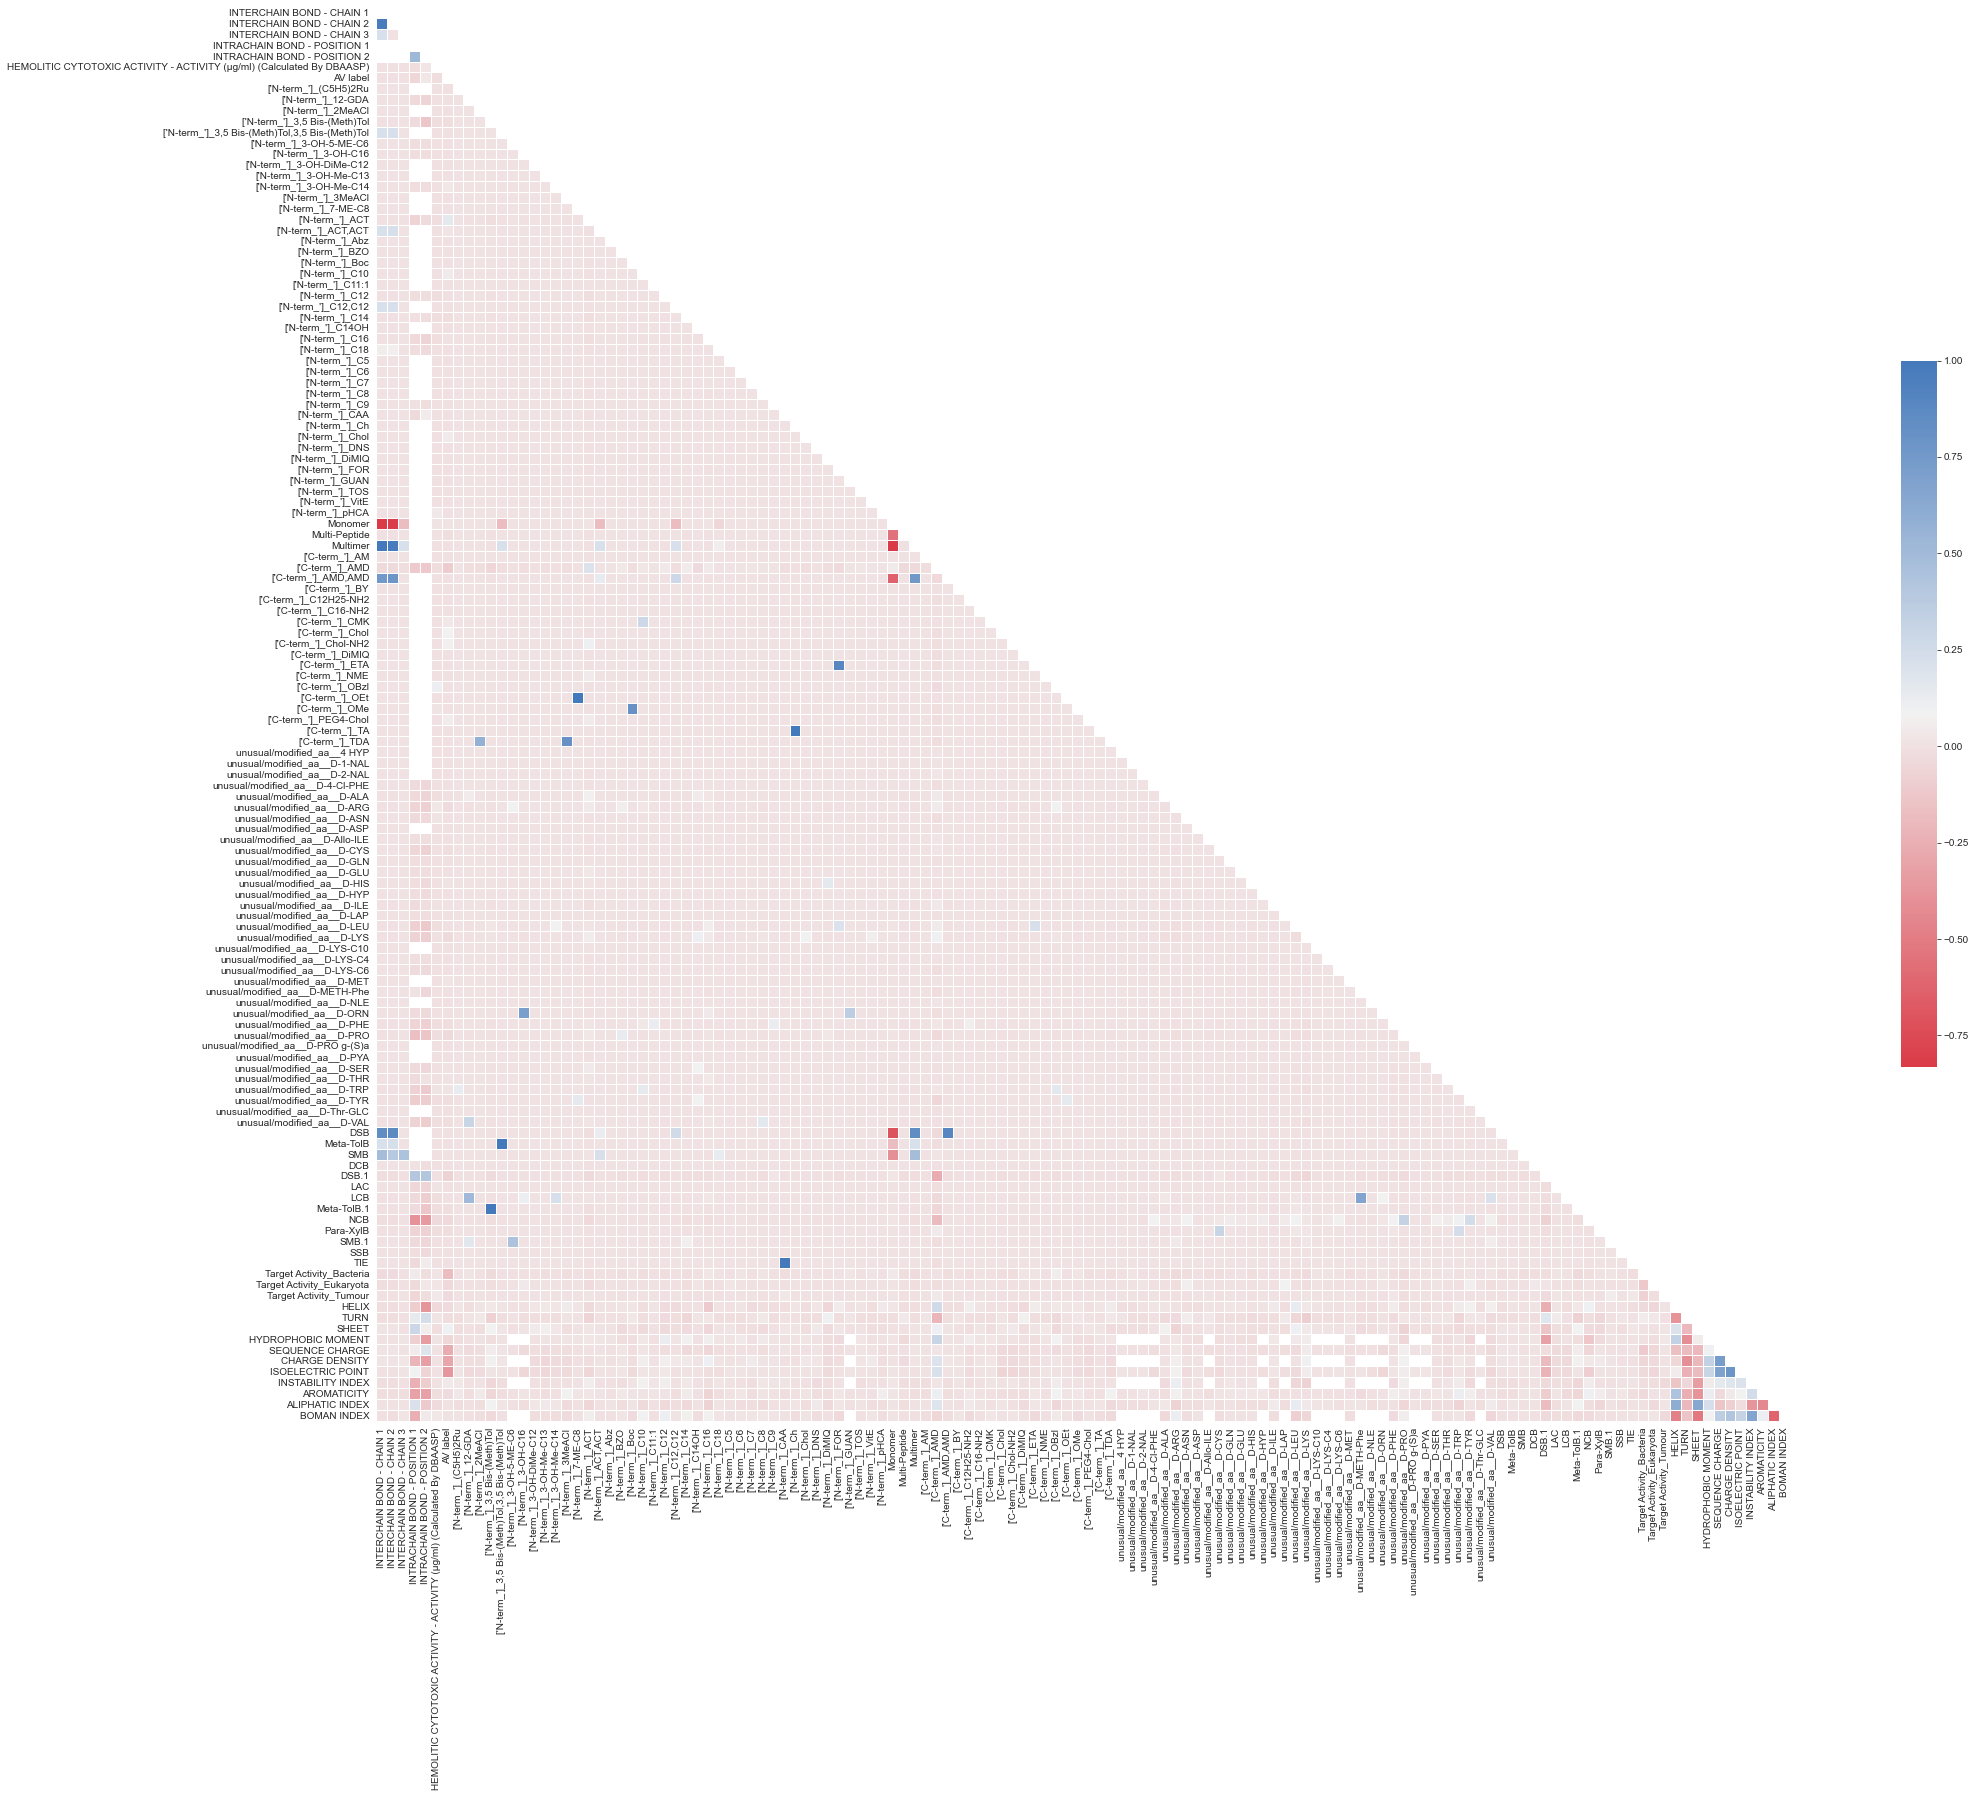

In [15]:
# use the pandas .corr() method to compute pairwise correlations for the dataframe
corr = data.corr()
# visualise the data with seaborn
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(40, 26))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.75, cbar_kws={"shrink": .5}, ax=ax)

In [16]:
# Create interactive plot for better visualisation
heat = go.Heatmap(
    z = corr,
    x = corr.columns.values,
    y = corr.columns.values,
    zmin = - 0.5, # Sets the lower bound of the color domain
    zmax = 1,
    xgap = 1, # Sets the horizontal gap (in pixels) between bricks
    ygap = 1,
    colorscale = 'RdBu'
)

layout = go.Layout(
    title_text='Feature Correlation Matrix', 
    title_x=0.5, 
    width=2000, 
    height=2000,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange='reversed'
)

fig=go.Figure(data=[heat], layout=layout)
fig.update_xaxes(tickfont=dict(size=9))
fig.update_yaxes(tickfont=dict(size=9))
fig.show()

The correlation plot provides insight into which features are highly correlated and are therefore redundant to our prediction pipeline.

In [17]:
# Drop features that have high correlations with other existing features
# Intuitively, it makes sense monomer vs multimer info is represented in info on interchain bonds
data_filt = data.drop(["INTERCHAIN BOND - CHAIN 2","Monomer","Multimer","DSB","TIE","['C-term_']_TA"], axis=1)

In [18]:
data_filt = data_filt.fillna(0)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# Spliiting data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(data_filt.drop('AV label', axis=1), data_filt['AV label'], 
                                                    test_size=0.20, random_state=0)
# fitting the model
model = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [20]:
# plotting feature importances
features = data_filt.drop('AV label', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)

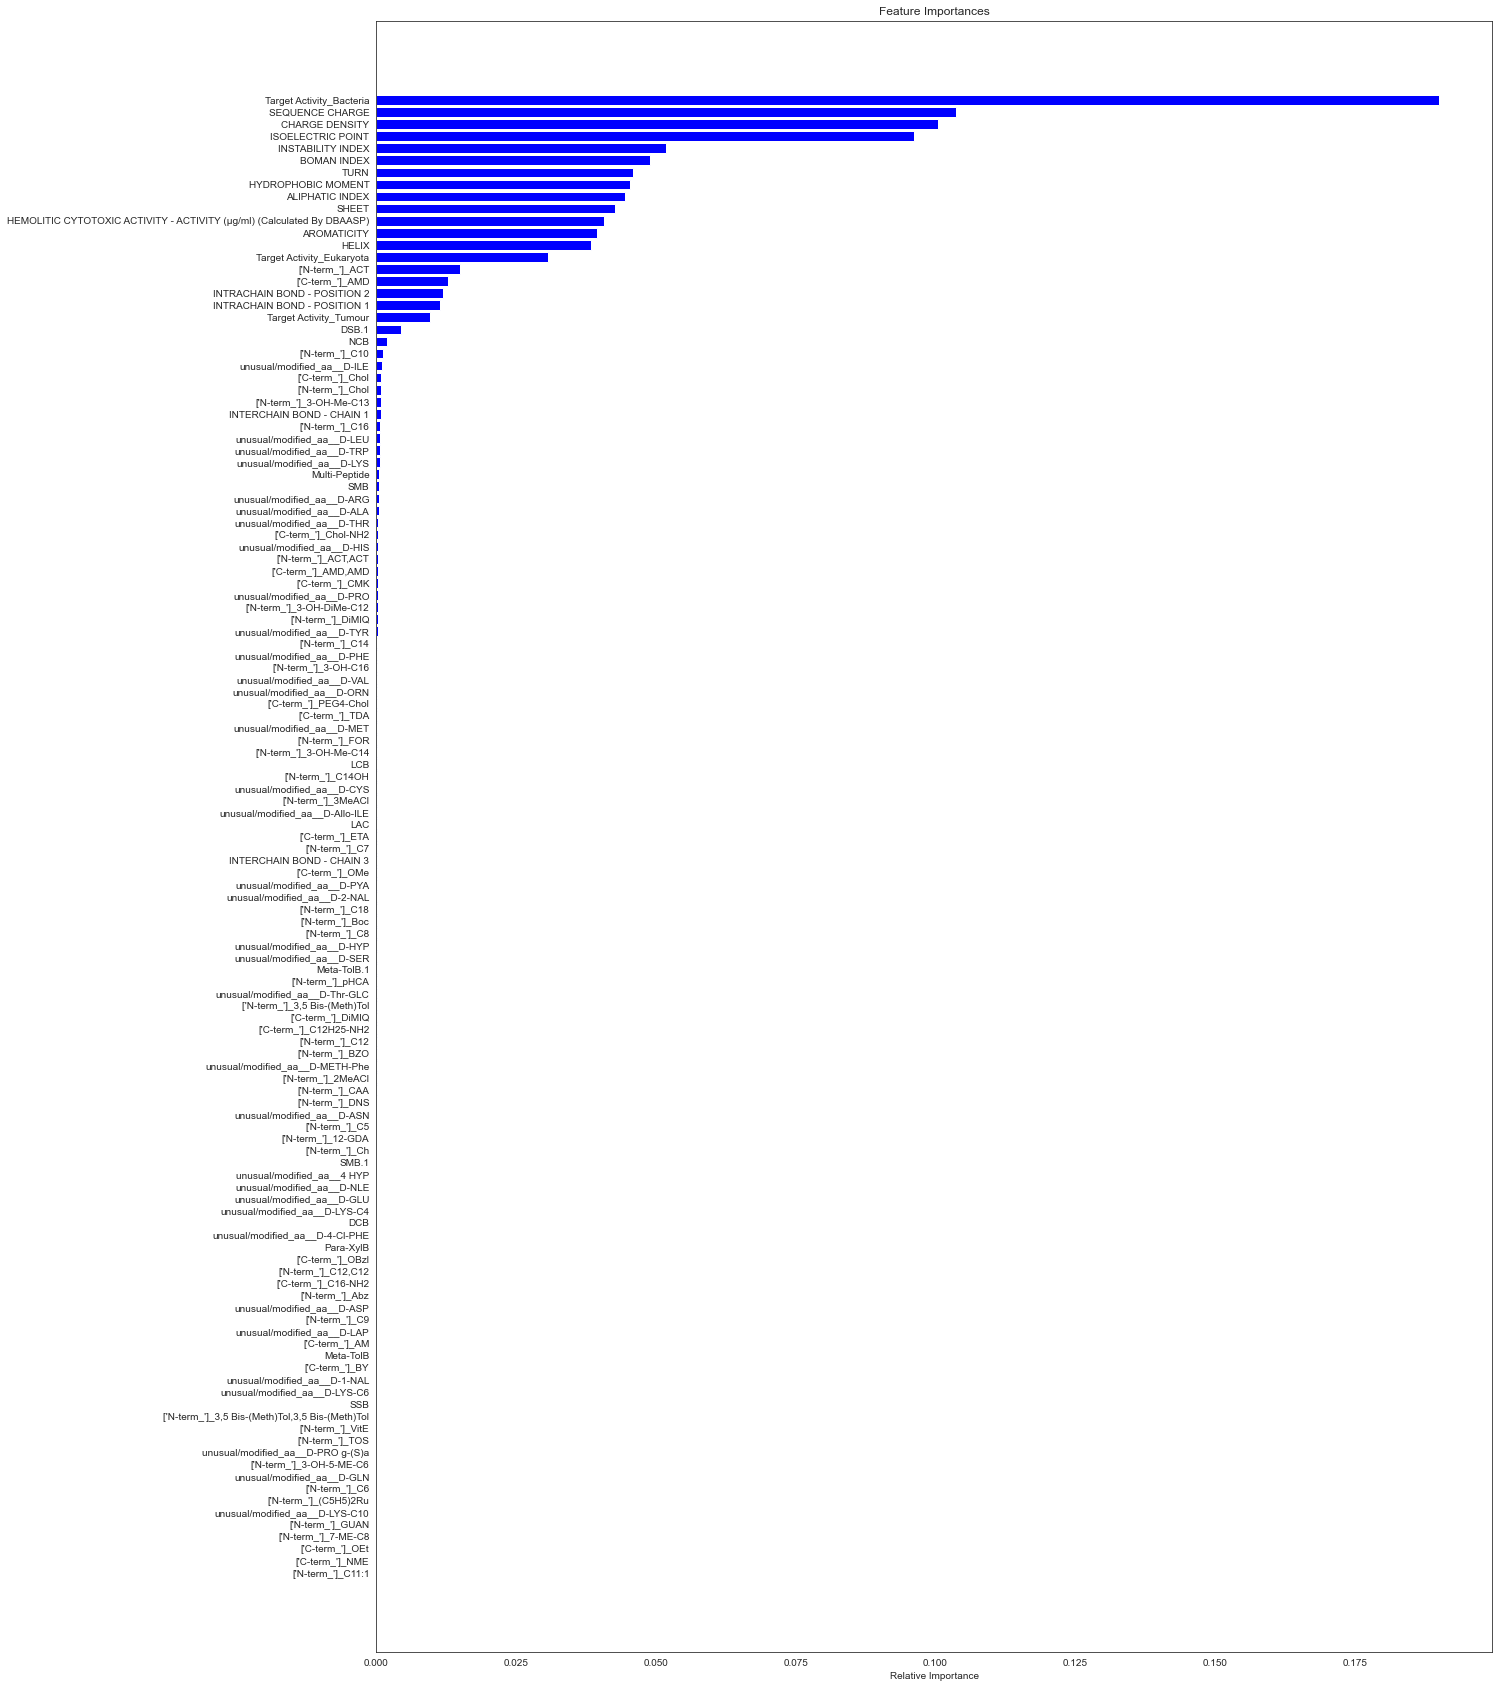

In [21]:
plt.figure(figsize=(20,30))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [22]:
# Create interactive plot for better visualisation
df = pd.DataFrame([features[i] for i in indices], columns=["Features"])
df["Relative Importance"] = importances[indices]
df.sort_values("Relative Importance", ascending=False, inplace=True, ignore_index=True)

fig = px.bar(df.iloc[:30], x="Relative Importance", y="Features",orientation='h',
                title="Feature Importances")
fig.update_layout(yaxis=dict(autorange="reversed"), title_x=0.5)
fig.update_yaxes(tickfont=dict(size=8))
fig.show()

In [23]:
# select top 25 features
top_25 = np.argsort(importances)[-25:]
top_features = features[top_25]

In [24]:
selected_data = data_filt[list(top_features)+["AV label"]]

In [26]:
selected_data.to_json("selected_feats_amp.json", orient="records", indent=2)

Although my approach involves manual feature selection using Random Forest Classifier, the following blocks of code can be run prior to model training to select features using sklearn's built-in utilities

In [10]:
from sklearn.feature_selection import VarianceThreshold
X = data.drop('AV label', axis=1)
selector = VarianceThreshold(0.2)
print("Original feature shape:", X.shape)
new_X = selector.fit_transform(X)
print("Transformed feature shape:", new_X.shape)

Original feature shape: (13713, 129)
Transformed feature shape: (13713, 12)


In [16]:
# univariate feature selection
from sklearn.feature_selection import SelectKBest
X = data_filledna.drop('AV label', axis=1)
y = data_filledna['AV label']
selector = SelectKBest(k=25)
print("Original feature shape:", X.shape)
new_X = selector.fit_transform(X, y)
print("Transformed feature shape:", new_X.shape)

Original feature shape: (13713, 129)
Transformed feature shape: (13713, 25)
